## Load NASBench library and dataset

In [ ]:

from nasbench import api

# Use nasbench_full.tfrecord for full dataset (run download command above).
nasbench = api.NASBench('nasbench_only108.tfrecord')




Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 19 seconds


In [2]:
# Standard imports
import copy
import numpy as np
import matplotlib.pyplot as plt
import random

# Useful constants
INPUT = 'input'
OUTPUT = 'output'
CONV3X3 = 'conv3x3-bn-relu'
CONV1X1 = 'conv1x1-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'
NUM_VERTICES = 7
MAX_EDGES = 9
EDGE_SPOTS = NUM_VERTICES * (NUM_VERTICES - 1) / 2   # Upper triangular matrix
OP_SPOTS = NUM_VERTICES - 2   # Input/output vertices are fixed
ALLOWED_OPS = [CONV3X3, CONV1X1, MAXPOOL3X3]
ALLOWED_EDGES = [0, 1]   # Binary adjacency matrix

## Basic usage

In [3]:
# Query an Inception-like cell from the dataset.
cell = api.ModelSpec(
  matrix=[[0, 1, 1, 1, 0, 1, 0],    # input layer
          [0, 0, 0, 0, 0, 0, 1],    # 1x1 conv
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 conv
          [0, 0, 0, 0, 1, 0, 0],    # 5x5 conv (replaced by two 3x3's)
          [0, 0, 0, 0, 0, 0, 1],    # 5x5 conv (replaced by two 3x3's)
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 max-pool
          [0, 0, 0, 0, 0, 0, 0]],   # output layer
  # Operations at the vertices of the module, matches order of matrix.
  ops=[INPUT, CONV1X1, CONV3X3, CONV3X3, CONV3X3, MAXPOOL3X3, OUTPUT])

# Querying multiple times may yield different results. Each cell is evaluated 3
# times at each epoch budget and querying will sample one randomly.
data = nasbench.query(cell)
for k, v in data.items():
  print('%s: %s' % (k, str(v)))

module_adjacency: [[0 1 1 1 1 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
module_operations: ['input', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'output']
trainable_parameters: 2694282
training_time: 1155.85302734375
train_accuracy: 1.0
validation_accuracy: 0.9376001358032227
test_accuracy: 0.9311898946762085


## Example search experiment (random vs. evolution)

In [4]:
def random_spec():
  """Returns a random valid spec."""
  while True:
    matrix = np.random.choice(ALLOWED_EDGES, size=(NUM_VERTICES, NUM_VERTICES))
    matrix = np.triu(matrix, 1)
    ops = np.random.choice(ALLOWED_OPS, size=(NUM_VERTICES)).tolist()
    ops[0] = INPUT
    ops[-1] = OUTPUT
    spec = api.ModelSpec(matrix=matrix, ops=ops)
    if nasbench.is_valid(spec):
      return spec

def mutate_spec(old_spec, mutation_rate=1.0):
  """Computes a valid mutated spec from the old_spec."""
  
  new_matrix = copy.deepcopy(old_spec.original_matrix)
  new_ops = copy.deepcopy(old_spec.original_ops)

  # In expectation, V edges flipped (note that most end up being pruned).
  edge_mutation_prob = mutation_rate / NUM_VERTICES
  for src in range(0, NUM_VERTICES - 1):
    for dst in range(src + 1, NUM_VERTICES):
      if random.random() < edge_mutation_prob:
        new_matrix[src, dst] = 1 - new_matrix[src, dst]
        
  # In expectation, one op is resampled.
  op_mutation_prob = mutation_rate / OP_SPOTS
  for ind in range(1, NUM_VERTICES - 1):
    if random.random() < op_mutation_prob:
      available = [o for o in nasbench.config['available_ops'] if o != new_ops[ind]]
      new_ops[ind] = random.choice(available)
      
  new_spec = api.ModelSpec(new_matrix, new_ops)
  
  return new_spec

def crossover_spec(spec1, spec2, crossover_rate):
    """邻接矩阵按行随机 + 操作向量按位置随机交叉"""
    # 邻接矩阵交叉
    if random.random() > crossover_rate:
        return copy.deepcopy(random.choice([spec1, spec2]))
    
    mat1 = spec1.original_matrix
    mat2 = spec2.original_matrix
    new_mat = np.zeros_like(mat1)
    for i in range(mat1.shape[0]):
        new_mat[i] = mat1[i] if random.random() < 0.5 else mat2[i]
    ops1=spec1.original_ops
    ops2=spec2.original_ops
    # 操作向量交叉
    new_ops = []
    for i in range(len(ops1)):
        if i == 0:
            new_ops.append(ops1[0])   # input
        elif i == len(ops1)-1:
            new_ops.append(ops1[-1])  # output
        else:
            new_ops.append(ops1[i] if random.random() < 0.5 else ops2[i])
    new_spec= api.ModelSpec(new_mat, new_ops)
    
    return new_spec

def random_combination(iterable, sample_size):
  """Random selection from itertools.combinations(iterable, r)."""
  pool = tuple(iterable)
  n = len(pool)
  indices = sorted(random.sample(range(n), sample_size))
  return tuple(pool[i] for i in indices)

def run_random_search(max_time_budget=5e6):
  """Run a single roll-out of random search to a fixed time budget."""
  nasbench.reset_budget_counters()
  times, best_valids, best_tests = [0.0], [0.0], [0.0]
  while True:
    spec = random_spec()
    data = nasbench.query(spec)

    # It's important to select models only based on validation accuracy, test
    # accuracy is used only for comparing different search trajectories.
    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)
    if time_spent > max_time_budget:
      # Break the first time we exceed the budget.
      break

  return times, best_valids, best_tests

def run_evolution_search(max_time_budget=5e6,
                         population_size=100,
                         tournament_size=10,
                         crossover_rate=0.3,
                         mutation_rate=1.0):
  """Run a single roll-out of regularized evolution to a fixed time budget."""
  nasbench.reset_budget_counters()
  times, best_valids, best_tests = [0.0], [0.0], [0.0]
  population = []   # (validation, spec) tuples

  # For the first population_size individuals, seed the population with randomly
  # generated cells.

  
  for _ in range(population_size):
    spec = random_spec()
    data = nasbench.query(spec)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)
    population.append((data['validation_accuracy'], spec))

    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    if time_spent > max_time_budget:
      break

  # After the population is seeded, proceed with evolving the population.
  while True:
    while True:
      sample = random_combination(population, tournament_size)
      par1 = sorted(sample, key=lambda i:i[0])[-1][1]
      sample = random_combination(population, tournament_size)
      par2 = sorted(sample, key=lambda i:i[0])[-1][1]
      child_spec = crossover_spec(par1, par2, crossover_rate)
      new_spec = mutate_spec(child_spec, mutation_rate)
      if nasbench.is_valid(new_spec):
          break

    data = nasbench.query(new_spec)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)

    # In regularized evolution, we kill the oldest individual in the population.
    population.append((data['validation_accuracy'], new_spec))
    population.pop(0)
    
    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    if time_spent > max_time_budget:
      break

  return times, best_valids, best_tests


def run_evolution_search_nocross(max_time_budget=5e6,
                         population_size=50,
                         tournament_size=10,
                         mutation_rate=1.0):
  """Run a single roll-out of regularized evolution to a fixed time budget."""
  nasbench.reset_budget_counters()
  times, best_valids, best_tests = [0.0], [0.0], [0.0]
  population = []   # (validation, spec) tuples

  # For the first population_size individuals, seed the population with randomly
  # generated cells.
  for _ in range(population_size):
    spec = random_spec()
    data = nasbench.query(spec)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)
    population.append((data['validation_accuracy'], spec))

    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    if time_spent > max_time_budget:
      break

  # After the population is seeded, proceed with evolving the population.
  while True:
    while True:
      sample = random_combination(population, tournament_size)
      best_spec = sorted(sample, key=lambda i:i[0])[-1][1]
      new_spec = mutate_spec(best_spec, mutation_rate)
      if nasbench.is_valid(new_spec):
          break

    data = nasbench.query(new_spec)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)

    # In regularized evolution, we kill the oldest individual in the population.
    population.append((data['validation_accuracy'], new_spec))
    population.pop(0)

    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    if time_spent > max_time_budget:
      break

  return times, best_valids, best_tests
  

Running repeat 1
Running repeat 2
Running repeat 3
Running repeat 4
Running repeat 5
Running repeat 6
Running repeat 7
Running repeat 8
Running repeat 9
Running repeat 10
Running repeat 1
Running repeat 2
Running repeat 3
Running repeat 4
Running repeat 5
Running repeat 6
Running repeat 7
Running repeat 8
Running repeat 9
Running repeat 10
Running repeat 1
Running repeat 2
Running repeat 3
Running repeat 4
Running repeat 5
Running repeat 6
Running repeat 7
Running repeat 8
Running repeat 9
Running repeat 10


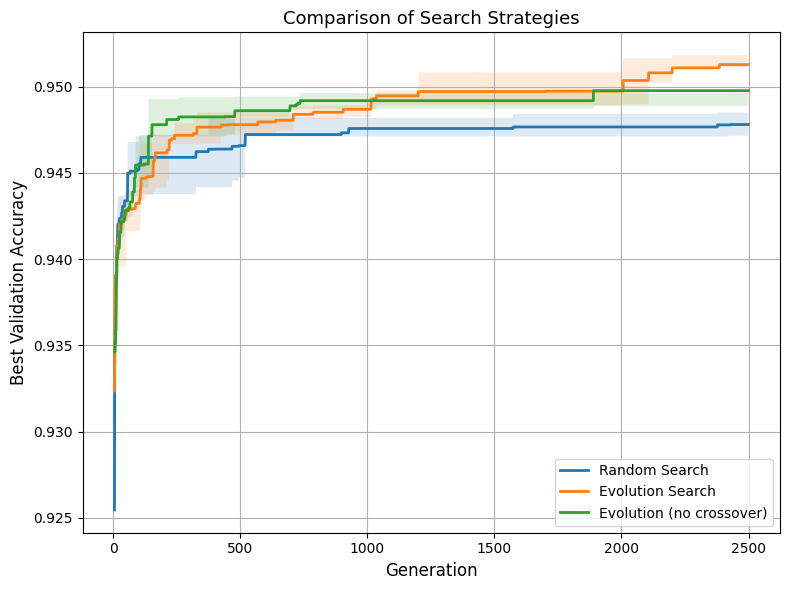

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time


N_REPEAT = 10
SKIP = 5
MAX_GEN = 2500  # 画前 2000 代


def collect_data(run_func):
    """重复 10 次，收集 best_valid 的序列（对齐 generation）"""
    all_vals = []
    for rep in range(N_REPEAT):
        seed = int(time.time())
        random.seed(seed)
        np.random.seed(seed)
        print(f"Running repeat {rep+1}")
        _, best_valid, _ = run_func()
        seq = best_valid[SKIP:MAX_GEN]
        all_vals.append(seq)
    return np.array(all_vals)   # shape = [10, T]


vals_r       = collect_data(run_random_search)
vals_e       = collect_data(run_evolution_search)
vals_e_nocro = collect_data(run_evolution_search_nocross)

# 对齐 generation
T = vals_r.shape[1]   # after cutting
xs = np.arange(SKIP, SKIP + T)


def compute_stats(arr):
    """输入 shape=(10, T)，输出均值、25%、75%"""
    mean  = arr.mean(axis=0)
    per25 = np.percentile(arr, 25, axis=0)
    per75 = np.percentile(arr, 75, axis=0)
    return mean, per25, per75

mean_r, p25_r, p75_r = compute_stats(vals_r)
mean_e, p25_e, p75_e = compute_stats(vals_e)
mean_nocro, p25_nocro, p75_nocro = compute_stats(vals_e_nocro)


plt.figure(figsize=(8,6))

def plot_with_iqr(x, mean, p25, p75, label):
    plt.plot(x, mean, linewidth=2, label=label)
    plt.fill_between(x, p25, p75, alpha=0.15)

plot_with_iqr(xs, mean_r,     p25_r,     p75_r,     "Random Search")
plot_with_iqr(xs, mean_e,     p25_e,     p75_e,     "Evolution Search")
plot_with_iqr(xs, mean_nocro, p25_nocro, p75_nocro, "Evolution (no crossover)")

plt.xlabel("Generation", fontsize=12)
plt.ylabel("Best Validation Accuracy", fontsize=12)
plt.title("Comparison of Search Strategies", fontsize=13)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Run random search and evolution search 10 times each. This should take a few
# minutes to run. Note that each run would have taken days of compute to
# actually train and evaluate if the dataset were not precomputed.
random_data = []
evolution_data = []
for repeat in range(10):
  print('Running repeat %d' % (repeat + 1))
  times, best_valid, best_test = run_random_search()
  
  random_data.append((times, best_valid, best_test))

  times, best_valid, best_test = run_evolution_search()
  evolution_data.append((times, best_valid, best_test))

Running repeat 1
Running repeat 2
Running repeat 3
Running repeat 4
Running repeat 5
Running repeat 6
Running repeat 7
Running repeat 8
Running repeat 9
Running repeat 10


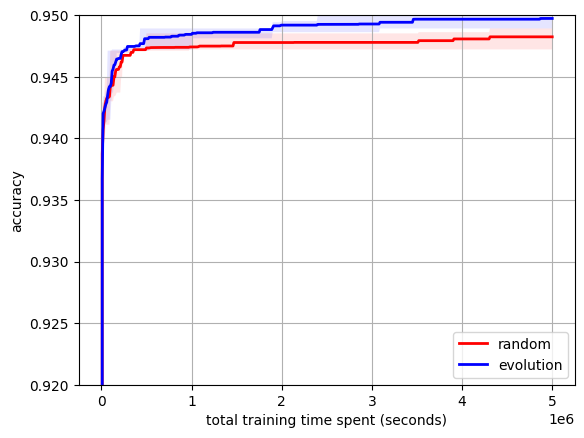

In [ ]:
# Compare the mean test accuracy along with error bars.
def plot_data(data, color, label, gran=10000, max_budget=5000000):
  """Computes the mean and IQR fixed time steps."""
  xs = range(0, max_budget+1, gran)
  mean = [0.0]
  per25 = [0.0]
  per75 = [0.0]
  
  repeats = len(data)
  pointers = [1 for _ in range(repeats)]
  
  cur = gran
  while cur < max_budget+1:
    all_vals = []
    for repeat in range(repeats):
      while (pointers[repeat] < len(data[repeat][0]) and 
             data[repeat][0][pointers[repeat]] < cur):
        pointers[repeat] += 1
      prev_time = data[repeat][0][pointers[repeat]-1]
      prev_test = data[repeat][1][pointers[repeat]-1]
      next_time = data[repeat][0][pointers[repeat]]
      next_test = data[repeat][1][pointers[repeat]]
      assert prev_time < cur and next_time >= cur

      # Linearly interpolate the test between the two surrounding points
      cur_val = ((cur - prev_time) / (next_time - prev_time)) * (next_test - prev_test) + prev_test
      
      all_vals.append(cur_val)
      
    all_vals = sorted(all_vals)
    mean.append(sum(all_vals) / float(len(all_vals)))
    per25.append(all_vals[int(0.25 * repeats)])
    per75.append(all_vals[int(0.75 * repeats)])
      
    cur += gran
    
  plt.plot(xs, mean, color=color, label=label, linewidth=2)
  plt.fill_between(xs, per25, per75, alpha=0.1, linewidth=0, facecolor=color)

plot_data(random_data, 'red', 'random')
plot_data(evolution_data, 'blue', 'evolution')
plt.legend(loc='lower right')
plt.ylim(0.92, 0.95)
plt.xlabel('total training time spent (seconds)')
plt.ylabel('accuracy')
plt.grid()